In [25]:
import torch
import torchvision.datasets as datasets
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Subset
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report
from torch.autograd import Function
import math
import random
import os
import torch.utils.data
import torchvision

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [12]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to range [-1, 1]
])

# Source Dataset (e.g., MNIST)
source_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
source_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

target_train_dataset = datasets.SVHN(root='./data', split='train', download=False, transform=transform)
target_test_dataset = datasets.SVHN(root='./data', split='test', download=False, transform=transform)

batch_size = 64
source_train_loader = DataLoader(dataset=source_train_dataset, batch_size=batch_size, shuffle=True)
source_test_loader = DataLoader(dataset=source_test_dataset, batch_size=batch_size, shuffle=False)
target_train_loader = DataLoader(dataset=target_train_dataset, batch_size=batch_size, shuffle=True)
target_test_loader = DataLoader(dataset=target_test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Splitting the MNIST dataset into train and validation sets
train_size = int(0.8 * len(source_train_dataset))
validation_size = len(source_train_dataset) - train_size
train_dataset, validation_dataset = random_split(source_train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

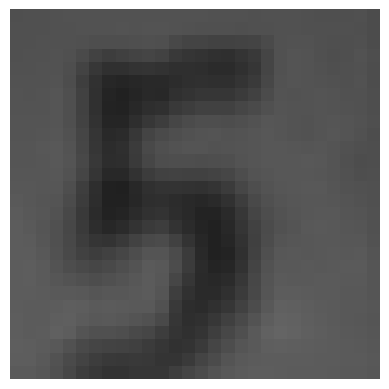

Labels: tensor(5)


In [14]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(target_test_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0]))
print('Labels:', labels[0])

# Logistic Regression

Validation Accuracy Improved: 88.28% Saving Model
Epoch [1/50], Train Accuracy: 88.16%, Val Accuracy: 88.28%, Test Accuracy: 15.10%
Validation Accuracy Improved: 89.57% Saving Model
Epoch [2/50], Train Accuracy: 89.33%, Val Accuracy: 89.57%, Test Accuracy: 14.36%
Validation Accuracy Improved: 90.08% Saving Model
Epoch [3/50], Train Accuracy: 90.03%, Val Accuracy: 90.08%, Test Accuracy: 15.28%
Validation Accuracy Improved: 90.82% Saving Model
Epoch [4/50], Train Accuracy: 90.52%, Val Accuracy: 90.82%, Test Accuracy: 14.32%
Validation Accuracy: 90.42%, No Improvement: 1 Epoch(s)
Epoch [5/50], Train Accuracy: 90.40%, Val Accuracy: 90.42%, Test Accuracy: 15.11%
Validation Accuracy Improved: 91.10% Saving Model
Epoch [6/50], Train Accuracy: 90.97%, Val Accuracy: 91.10%, Test Accuracy: 14.61%
Validation Accuracy: 91.01%, No Improvement: 1 Epoch(s)
Epoch [7/50], Train Accuracy: 91.14%, Val Accuracy: 91.01%, Test Accuracy: 14.41%
Validation Accuracy Improved: 91.28% Saving Model
Epoch [8/50], 

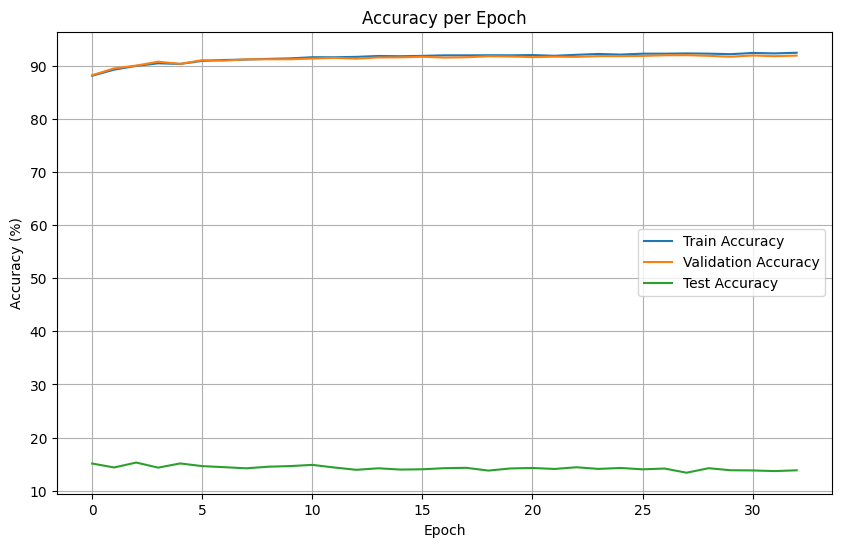

In [15]:
# Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x)

# Initialize the model
model = LogisticRegressionModel().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Function to compute the accuracy of the model
def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train the model with early stopping
def train_model(num_epochs, patience):
    model.train()
    best_accuracy = 0
    epochs_no_improve = 0
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy = compute_accuracy(train_loader)
        val_accuracy = compute_accuracy(validation_loader)
        test_accuracy = compute_accuracy(target_test_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            print(f'Validation Accuracy Improved: {best_accuracy:.2f}% Saving Model')
        else:
            epochs_no_improve += 1
            print(f'Validation Accuracy: {val_accuracy:.2f}%, No Improvement: {epochs_no_improve} Epoch(s)')
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_accuracies, val_accuracies, test_accuracies

# Set a patience level
patience_level = 5
train_accuracies, val_accuracies, test_accuracies = train_model(50, patience_level)  # Train for maximum 50 epochs or until early stopping

# Load the best model and test
model.load_state_dict(torch.load('best_model.pth'))
print(f'Accuracy of the best model on test set: {compute_accuracy(target_test_loader):.2f}%')

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()



In [16]:
def compute_f1_score(loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    report = classification_report(all_labels, all_preds)
    print(report)

compute_f1_score(train_loader)
compute_f1_score(target_test_loader)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4771
           1       0.96      0.97      0.96      5379
           2       0.94      0.89      0.91      4776
           3       0.91      0.90      0.90      4919
           4       0.93      0.93      0.93      4655
           5       0.87      0.89      0.88      4356
           6       0.94      0.96      0.95      4728
           7       0.92      0.95      0.93      5030
           8       0.87      0.89      0.88      4638
           9       0.92      0.89      0.90      4748

    accuracy                           0.92     48000
   macro avg       0.92      0.92      0.92     48000
weighted avg       0.92      0.92      0.92     48000

              precision    recall  f1-score   support

           0       0.06      0.13      0.08      1744
           1       0.24      0.17      0.20      5099
           2       0.32      0.12      0.17      4149
           3       0.21 

# CNN

Validation Accuracy Improved: 88.26% Saving Model
Epoch [1/50], Train Accuracy: 88.02%, Val Accuracy: 88.26%, Test Accuracy: 18.19%
Validation Accuracy Improved: 94.18% Saving Model
Epoch [2/50], Train Accuracy: 94.22%, Val Accuracy: 94.18%, Test Accuracy: 23.92%
Validation Accuracy Improved: 95.70% Saving Model
Epoch [3/50], Train Accuracy: 95.87%, Val Accuracy: 95.70%, Test Accuracy: 26.67%
Validation Accuracy Improved: 96.59% Saving Model
Epoch [4/50], Train Accuracy: 96.72%, Val Accuracy: 96.59%, Test Accuracy: 28.90%
Validation Accuracy Improved: 97.00% Saving Model
Epoch [5/50], Train Accuracy: 97.21%, Val Accuracy: 97.00%, Test Accuracy: 29.91%
Validation Accuracy Improved: 97.46% Saving Model
Epoch [6/50], Train Accuracy: 97.62%, Val Accuracy: 97.46%, Test Accuracy: 29.66%
Validation Accuracy Improved: 97.62% Saving Model
Epoch [7/50], Train Accuracy: 97.79%, Val Accuracy: 97.62%, Test Accuracy: 31.53%
Validation Accuracy Improved: 97.80% Saving Model
Epoch [8/50], Train Accura

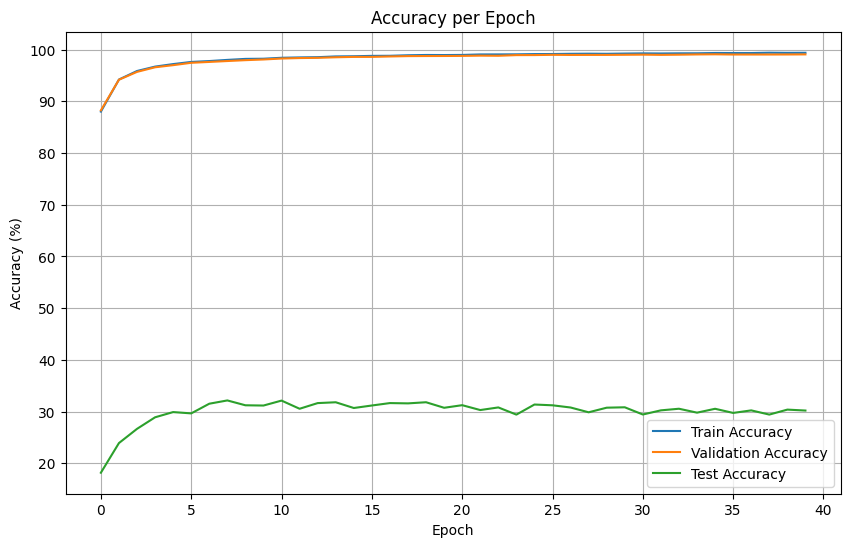

In [17]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Function to compute the accuracy of the model
def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train the model with early stopping and track accuracies
def train_model(num_epochs, patience):
    model.train()
    best_accuracy = 0
    epochs_no_improve = 0
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy = compute_accuracy(train_loader)
        val_accuracy = compute_accuracy(validation_loader)
        test_accuracy = compute_accuracy(target_test_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            print(f'Validation Accuracy Improved: {best_accuracy:.2f}% Saving Model')
        else:
            epochs_no_improve += 1
            print(f'Validation Accuracy: {val_accuracy:.2f}%, No Improvement: {epochs_no_improve} Epoch(s)')
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_accuracies, val_accuracies, test_accuracies

# Set a patience level
patience_level = 5
train_accuracies, val_accuracies, test_accuracies = train_model(50, patience_level)  # Train for maximum 50 epochs or until early stopping

# Load the best model and test
model.load_state_dict(torch.load('best_model.pth'))
print(f'Accuracy of the best model on test set: {compute_accuracy(target_test_loader):.2f}%')

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
def compute_f1_score(loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    report = classification_report(all_labels, all_preds)
    print(report)

compute_f1_score(train_loader)
compute_f1_score(target_test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4771
           1       1.00      1.00      1.00      5379
           2       0.99      0.99      0.99      4776
           3       1.00      0.99      0.99      4919
           4       0.99      0.99      0.99      4655
           5       1.00      0.99      0.99      4356
           6       0.99      1.00      0.99      4728
           7       0.99      1.00      0.99      5030
           8       0.99      0.99      0.99      4638
           9       0.99      0.99      0.99      4748

    accuracy                           0.99     48000
   macro avg       0.99      0.99      0.99     48000
weighted avg       0.99      0.99      0.99     48000

              precision    recall  f1-score   support

           0       0.13      0.41      0.20      1744
           1       0.58      0.33      0.42      5099
           2       0.62      0.36      0.46      4149
           3       0.54 

# Deep CORAL

In [19]:
CUDA = True if torch.cuda.is_available() else False


'''
MODELS
'''


def CORAL(source, target):
    d = source.data.shape[1]

    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = xm.t() @ xm

    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = xmt.t() @ xmt

    # frobenius norm between source and target
    loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
    loss = loss/(4*d*d)

    return loss


class DeepCORAL(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepCORAL, self).__init__()
        self.sharedNet = CNN()
        self.fc = nn.Linear(10, num_classes)

        # initialize according to CORAL paper experiment
        self.fc.weight.data.normal_(0, 0.005)

    def forward(self, source, target):
        source = self.sharedNet(source)
        source = self.fc(source)

        target = self.sharedNet(target)
        target = self.fc(target)
        return source, target


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Epoch [1/50], Loss: 1.1665, Cls Loss: 0.9769, CORAL Loss: 0.1896, Train Accuracy: 0.9732, Test Accuracy: 0.1624
Epoch [2/50], Loss: 0.8632, Cls Loss: 0.6393, CORAL Loss: 0.2239, Train Accuracy: 0.9810, Test Accuracy: 0.1735
Epoch [3/50], Loss: 0.8229, Cls Loss: 0.5987, CORAL Loss: 0.2242, Train Accuracy: 0.9834, Test Accuracy: 0.1967
Epoch [4/50], Loss: 0.8065, Cls Loss: 0.5815, CORAL Loss: 0.2250, Train Accuracy: 0.9860, Test Accuracy: 0.1867
Epoch [5/50], Loss: 0.7839, Cls Loss: 0.5593, CORAL Loss: 0.2246, Train Accuracy: 0.9867, Test Accuracy: 0.1353
Epoch [6/50], Loss: 0.7717, Cls Loss: 0.5476, CORAL Loss: 0.2241, Train Accuracy: 0.9880, Test Accuracy: 0.1410
Epoch [7/50], Loss: 0.7666, Cls Loss: 0.5425, CORAL Loss: 0.2241, Train Accuracy: 0.9867, Test Accuracy: 0.1133
Epoch [8/50], Loss: 0.7573, Cls Loss: 0.5328, CORAL Loss: 0.2244, Train Accuracy: 0.9886, Test Accuracy: 0.0969
Epoch [9/50], Loss: 0.7537, Cls Loss: 0.5286, CORAL Loss: 0.2251, Train Accuracy: 0.9880, Test Accuracy:

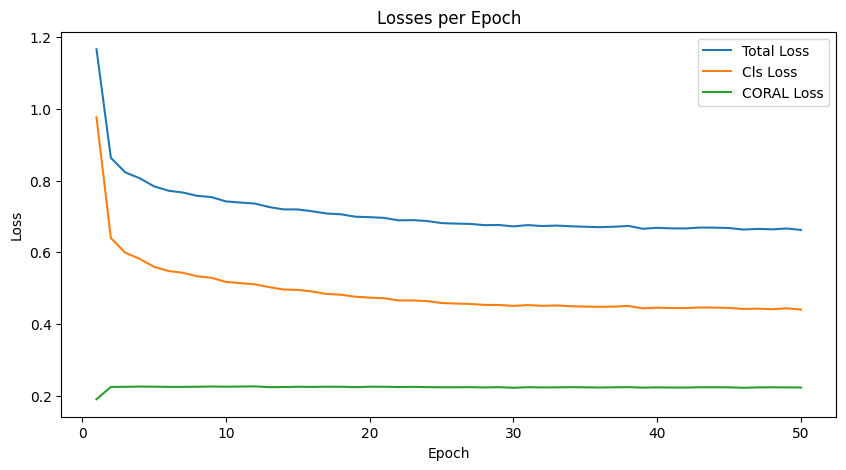

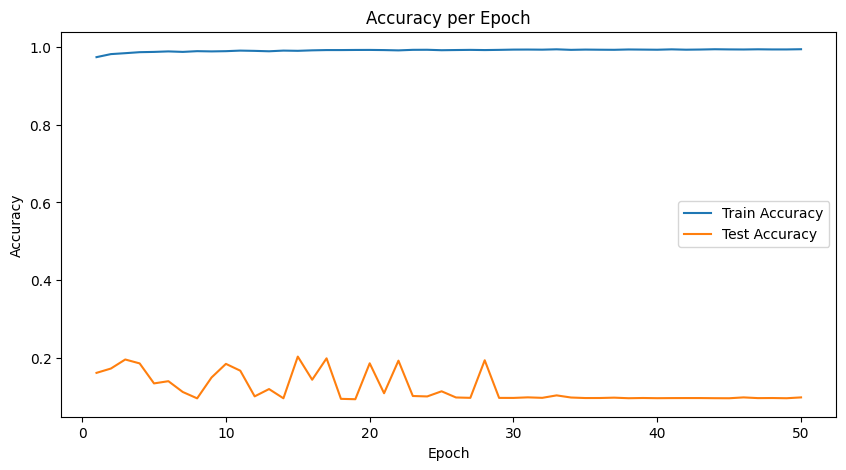

In [20]:
model = DeepCORAL(num_classes=10)
if CUDA:
    model = model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Lists to store losses and accuracies
total_losses = []
cls_losses = []
coral_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_cls_loss = 0
    total_coral_loss = 0

    for (source_data, source_labels), (target_data, _) in zip(source_train_loader, target_train_loader):
        if CUDA:
            source_data, source_labels = source_data.cuda(), source_labels.cuda()
            target_data = target_data.cuda()

        optimizer.zero_grad()

        # Forward pass
        source_outputs, target_outputs = model(source_data, target_data)

        # Compute classification loss on source data
        cls_loss = criterion(source_outputs, source_labels)

        # Compute CORAL loss
        coral_loss = CORAL(source_outputs, target_outputs)

        # Total loss
        loss = cls_loss + coral_loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_coral_loss += coral_loss.item()

    # Store losses
    total_losses.append(total_loss / len(source_train_loader))
    cls_losses.append(total_cls_loss / len(source_train_loader))
    coral_losses.append(total_coral_loss / len(source_train_loader))

    # Compute training accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for source_data, source_labels in source_train_loader:
            if CUDA:
                source_data, source_labels = source_data.cuda(), source_labels.cuda()
            outputs, _ = model(source_data, source_data)
            _, predicted = torch.max(outputs.data, 1)
            total += source_labels.size(0)
            correct += (predicted == source_labels).sum().item()
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    # Compute test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for target_data, target_labels in target_test_loader:
            if CUDA:
                target_data, target_labels = target_data.cuda(), target_labels.cuda()
            outputs, _ = model(target_data, target_data)
            _, predicted = torch.max(outputs.data, 1)
            total += target_labels.size(0)
            correct += (predicted == target_labels).sum().item()
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(source_train_loader):.4f}, '
          f'Cls Loss: {total_cls_loss / len(source_train_loader):.4f}, '
          f'CORAL Loss: {total_coral_loss / len(source_train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the losses and accuracies
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, cls_losses, label='Cls Loss')
plt.plot(epochs, coral_losses, label='CORAL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses per Epoch')
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

In [21]:
def test_model(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            if CUDA:
                data, labels = data.cuda(), labels.cuda()
            outputs = model.sharedNet(data)
            outputs = model.fc(outputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    report = classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)])
    print(report)
test_model(model,source_train_loader)
test_model(model,target_test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      0.99      0.99      6742
           2       0.99      0.99      0.99      5958
           3       1.00      0.99      1.00      6131
           4       0.99      0.99      0.99      5842
           5       0.99      0.99      0.99      5421
           6       0.99      1.00      1.00      5918
           7       0.99      0.99      0.99      6265
           8       1.00      0.99      0.99      5851
           9       0.99      0.99      0.99      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1744
           1       0.40      0.01      0.03      5099
           2       0.00      0.00      0.00      4149
           3       1.00 

c:\Users\vassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vassi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# ATM

In [26]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to range [-1, 1]
])

# Source Dataset (e.g., MNIST)
source_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
source_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)


target_train_dataset = datasets.SVHN(root='./data', split="train", transform=transform, download=False)
target_test_dataset = datasets.SVHN(root='./data', split="test", transform=transform, download=False)

batch_size = 64
source_test_loader = DataLoader(dataset=source_test_dataset, batch_size=batch_size, shuffle=False)
target_test_loader = DataLoader(dataset=target_test_dataset, batch_size=batch_size, shuffle=False)

num_samples_to_keep = 7168

# Create a subset of the dataset
subset_indices = list(range(num_samples_to_keep))
subset1 = Subset(source_train_dataset, subset_indices)
subset2 = Subset(target_train_dataset, subset_indices)

source_train_loader = DataLoader(dataset=subset1, batch_size=batch_size, shuffle=True)
target_train_loader = DataLoader(dataset=subset2, batch_size=batch_size, shuffle=False)
data_count1 = len(source_train_loader.dataset)
data_count2 = len(target_train_loader.dataset)

In [27]:
def Entropy(input_):
    epsilon = 1e-5
    entropy = -input_ * torch.log(input_ + epsilon)
    entropy = torch.sum(entropy, dim=1)
    return entropy


def grl_hook(coeff):
    def fun1(grad):
        return -coeff * grad.clone()

    return fun1


def CDAN(input_list, ad_net, entropy=None, coeff=None, random_layer=None):
    softmax_output = input_list[1].detach()
    feature = input_list[0]
    if random_layer is None:
        op_out = torch.bmm(softmax_output.unsqueeze(2), feature.unsqueeze(1))
        ad_out = ad_net(op_out.view(-1, softmax_output.size(1) * feature.size(1)))
    else:
        random_out = random_layer.forward([feature, softmax_output])
        ad_out = ad_net(random_out.view(-1, random_out.size(1)))
    batch_size = softmax_output.size(0) // 2
    dc_target = torch.from_numpy(np.array([[1]] * batch_size + [[0]] * batch_size)).float().cuda()
    if entropy is not None:
        entropy.register_hook(grl_hook(coeff))
        entropy = 1.0 + torch.exp(-entropy)
        source_mask = torch.ones_like(entropy)
        source_mask[feature.size(0) // 2:] = 0
        source_weight = entropy * source_mask
        target_mask = torch.ones_like(entropy)
        target_mask[0:feature.size(0) // 2] = 0
        target_weight = entropy * target_mask
        weight = source_weight / torch.sum(source_weight).detach().item() + \
                 target_weight / torch.sum(target_weight).detach().item()
        l = nn.BCELoss(reduction='none')(ad_out, dc_target)
        return torch.sum(weight.view(-1, 1) * nn.BCELoss()(ad_out, dc_target)) / torch.sum(weight).detach().item()
    else:
        return nn.BCELoss()(ad_out, dc_target)


def mdd_loss(features, labels, left_weight=1, right_weight=1):
    softmax_out = nn.Softmax(dim=1)(features)
    batch_size = features.size(0)
    if float(batch_size) % 2 != 0:
        raise Exception('Incorrect batch size provided')

    batch_left = softmax_out[:int(0.5 * batch_size)]
    batch_right = softmax_out[int(0.5 * batch_size):]

    loss = torch.norm((batch_left - batch_right).abs(), 2, 1).sum() / float(batch_size)

    labels_left = labels[:int(0.5 * batch_size)]
    batch_left_loss = get_pari_loss1(labels_left, batch_left)

    labels_right = labels[int(0.5 * batch_size):]
    batch_right_loss = get_pari_loss1(labels_right, batch_right)
    return loss + left_weight * batch_left_loss + right_weight * batch_right_loss


def mdd_digit(features, labels, left_weight=1, right_weight=1, weight=1):
    softmax_out = nn.Softmax(dim=1)(features)
    batch_size = features.size(0)
    if float(batch_size) % 2 != 0:
        raise Exception('Incorrect batch size provided')

    batch_left = softmax_out[:int(0.5 * batch_size)]
    batch_right = softmax_out[int(0.5 * batch_size):]

    loss = torch.norm((batch_left - batch_right).abs(), 2, 1).sum() / float(batch_size)

    labels_left = labels[:int(0.5 * batch_size)]
    labels_left_left = labels_left[:int(0.25 * batch_size)]
    labels_left_right = labels_left[int(0.25 * batch_size):]

    batch_left_left = batch_left[:int(0.25 * batch_size)]
    batch_left_right = batch_left[int(0.25 * batch_size):]
    batch_left_loss = get_pair_loss(labels_left_left, labels_left_right, batch_left_left, batch_left_right)

    labels_right = labels[int(0.5 * batch_size):]
    labels_right_left = labels_right[:int(0.25 * batch_size)]
    labels_right_right = labels_right[int(0.25 * batch_size):]

    batch_right_left = batch_right[:int(0.25 * batch_size)]
    batch_right_right = batch_right[int(0.25 * batch_size):]
    batch_right_loss = get_pair_loss(labels_right_left, labels_right_right, batch_right_left, batch_right_right)

    return weight*loss + left_weight * batch_left_loss + right_weight * batch_right_loss


def get_pair_loss(labels_left, labels_right, features_left, features_right):
    loss = 0
    for i in range(len(labels_left)):
        if (labels_left[i] == labels_right[i]):
            loss += torch.norm((features_left[i] - features_right[i]).abs(), 2, 0).sum()
    return loss


def get_pari_loss1(labels, features):
    loss = 0
    count = 0
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if (labels[i] == labels[j]):
                count += 1
                loss += torch.norm((features[i] - features[j]).abs(), 2, 0).sum()
    return loss / count


def EntropicConfusion(features):
    softmax_out = nn.Softmax(dim=1)(features)
    batch_size = features.size(0)
    loss = torch.mul(softmax_out, torch.log(softmax_out)).sum() * (1.0 / batch_size)
    return loss

In [28]:
def calc_coeff(iter_num, high=1.0, low=0.0, alpha=10.0, max_iter=10000.0):
    return float(2.0 * (high - low) / (1.0 + np.exp(-alpha * iter_num / max_iter)) - (high - low) + low)


def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        # nn.init.zeros_(m.bias)
        m.bias.data.fill_(0)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv_params = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        self.fc_params = nn.Sequential(nn.Linear(50 * 4 * 4, 500), nn.ReLU(), nn.Dropout(p=0.5))
        self.classifier = nn.Linear(500, 10)
        self.__in_features = 500

    def forward(self, x):
        x = self.conv_params(x)
        x = x.view(x.size(0), -1)
        x = self.fc_params(x)
        y = self.classifier(x)
        return x, y

    def output_num(self):
        return self.__in_features
class AdversarialNetwork(nn.Module):
    def __init__(self, in_feature, hidden_size):
        super(AdversarialNetwork, self).__init__()
        self.ad_layer1 = nn.Linear(in_feature, hidden_size)
        self.ad_layer2 = nn.Linear(hidden_size, hidden_size)
        self.ad_layer3 = nn.Linear(hidden_size, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.apply(init_weights)
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = 10000.0

    def forward(self, x):
        if self.training:
            self.iter_num += 1
        coeff = calc_coeff(self.iter_num, self.high, self.low, self.alpha, self.max_iter)
        x = x * 1.0
        x.register_hook(grl_hook(coeff))
        x = self.ad_layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.ad_layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        y = self.ad_layer3(x)
        y = self.sigmoid(y)
        return y

    def output_num(self):
        return 1

    def get_parameters(self):
        return [{"params": self.parameters(), "lr_mult": 10, 'decay_mult': 2}]

class RandomLayer(nn.Module):
    def __init__(self, input_dim_list=[], output_dim=1024):
        super(RandomLayer, self).__init__()
        self.input_num = len(input_dim_list)
        self.output_dim = output_dim
        self.random_matrix = [torch.randn(input_dim_list[i], output_dim) for i in range(self.input_num)]

    def forward(self, input_list):
        return_list = [torch.mm(input_list[i], self.random_matrix[i]) for i in range(self.input_num)]
        return_tensor = return_list[0] / math.pow(float(self.output_dim), 1.0 / len(return_list))
        for single in return_list[1:]:
            return_tensor = torch.mul(return_tensor, single)
        return return_tensor

    def cuda(self):
        super(RandomLayer, self).cuda()
        self.random_matrix = [val.cuda() for val in self.random_matrix]



epoch:1 Test set: Average loss: 0.0362, Accuracy: 4894/26032 (18.7999%)

epoch:2 Test set: Average loss: 0.0331, Accuracy: 7056/26032 (27.1051%)

epoch:3 Test set: Average loss: 0.0323, Accuracy: 7186/26032 (27.6045%)

epoch:4 Test set: Average loss: 0.0316, Accuracy: 7833/26032 (30.0899%)

epoch:5 Test set: Average loss: 0.0318, Accuracy: 7742/26032 (29.7403%)

epoch:6 Test set: Average loss: 0.0314, Accuracy: 8053/26032 (30.9350%)

epoch:7 Test set: Average loss: 0.0315, Accuracy: 7953/26032 (30.5509%)

epoch:8 Test set: Average loss: 0.0311, Accuracy: 7935/26032 (30.4817%)

epoch:9 Test set: Average loss: 0.0337, Accuracy: 7399/26032 (28.4227%)

epoch:10 Test set: Average loss: 0.0397, Accuracy: 6713/26032 (25.7875%)

epoch:11 Test set: Average loss: 0.0530, Accuracy: 6717/26032 (25.8029%)

epoch:12 Test set: Average loss: 0.0630, Accuracy: 6264/26032 (24.0627%)

epoch:13 Test set: Average loss: 0.0673, Accuracy: 5833/26032 (22.4070%)

epoch:14 Test set: Average loss: 0.0699, Accura

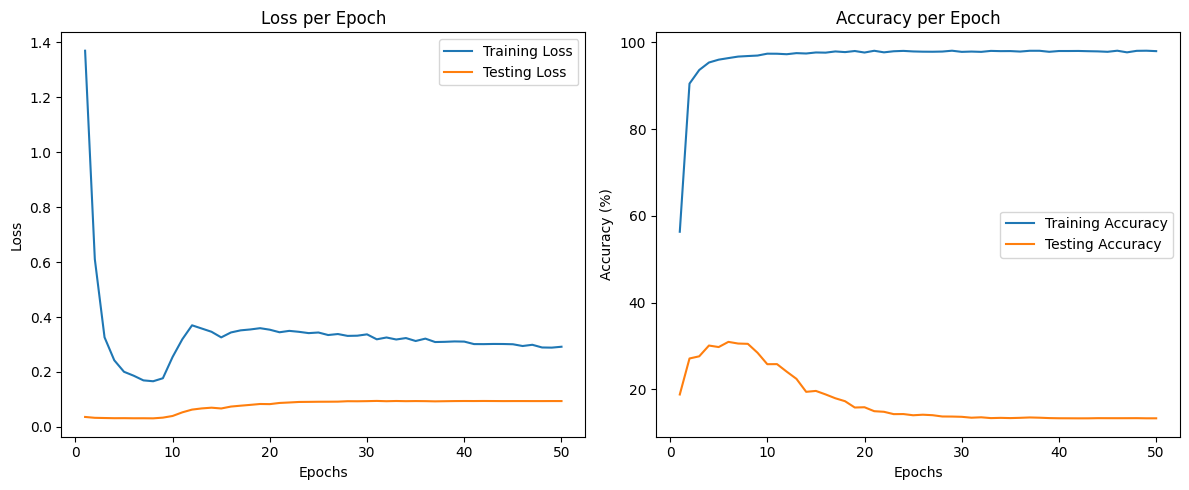

In [29]:
mdd_weight = 0.05
entropic_weight = 0
batch_size = 64
log_interval = 10

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, ad_net, random_layer, train_loader, train_loader1, optimizer, optimizer_ad, epoch, start_epoch):
    model.train()
    len_source = len(train_loader)
    len_target = len(train_loader1)
    if len_source > len_target:
        num_iter = len_source
    else:
        num_iter = len_target

    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx in range(num_iter):
        if batch_idx % len_source == 0:
            iter_source = iter(train_loader)
        if batch_idx % len_target == 0:
            iter_target = iter(train_loader1)
        data_source, label_source = next(iter_source)
        data_source, label_source = data_source.cuda(), label_source.cuda()
        data_target, label_target = next(iter_target)
        data_target = data_target.cuda()
        optimizer.zero_grad()
        optimizer_ad.zero_grad()
        feature_source, output_source = model(data_source)
        feature_target, output_target = model(data_target)
        feature = torch.cat((feature_source, feature_target), 0)
        output = torch.cat((output_source, output_target), 0)

        labels_target_fake = torch.max(nn.Softmax(dim=1)(output_target), 1)[1]
        labels = torch.cat((label_source, labels_target_fake))

        loss = nn.CrossEntropyLoss()(output.narrow(0, 0, data_source.size(0)), label_source)
        softmax_output = nn.Softmax(dim=1)(output)
        if epoch > start_epoch:
            entropy = Entropy(softmax_output)
            loss += CDAN([feature, softmax_output], ad_net, entropy,
                                   calc_coeff(num_iter * (epoch - start_epoch) + batch_idx), random_layer)

        loss = loss + mdd_weight * mdd_digit(
            feature, labels) + entropic_weight * EntropicConfusion(feature)

        loss.backward()
        optimizer.step()
        if epoch > start_epoch:
            optimizer_ad.step()

        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred[:data_source.size(0)].eq(label_source.view_as(pred[:data_source.size(0)])).sum().item()
        total += data_source.size(0)

    # Calculate average loss and accuracy for the epoch
    train_losses.append(epoch_loss / num_iter)
    train_accuracies.append(100. * correct / total)


def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            feature, output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))

    log_str = 'epoch:{} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(epoch,
                                                                                            test_loss, correct,
                                                                                            len(test_loader.dataset),
                                                                                            100. * correct / len(
                                                                                                test_loader.dataset))
    print(log_str)


# Assume `source_train_loader`, `target_train_loader`, and `target_test_loader` are already defined
model = LeNet().cuda()
class_num = 10
epochs = 50
decay_epoch = 5
lr = 0.01

random_layer = RandomLayer([model.output_num(), class_num], 500)
ad_net = AdversarialNetwork(500, 500)
random_layer.cuda()
ad_net = ad_net.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.0005, momentum=0.9)
optimizer_ad = optim.SGD(ad_net.parameters(), lr=lr, weight_decay=0.0005, momentum=0.9)

for epoch in range(1, epochs + 1):
    if epoch % decay_epoch == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] = param_group["lr"] * 0.5
    train(model, ad_net, random_layer, source_train_loader, target_train_loader, optimizer, optimizer_ad, epoch, 1)
    test(epoch, model, target_test_loader)

# Plotting
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
def generate_classification_report(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            feature, output = model(data)
            pred = output.data.cpu().max(1, keepdim=True)[1]
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    report = classification_report(all_targets, all_preds, target_names=[str(i) for i in range(class_num)])
    print(report)

# Call this function with your model and test loader


In [33]:
generate_classification_report(model, source_test_loader)
generate_classification_report(model, target_test_loader)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

              precision    recall  f1-score   support

           0       0.64      0.01      0.01      1744
           1       0.37      0.12      0.18      5099
           2       0.87      0.02      0.04      4149
           3       0.98 

# DANN

In [34]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    

class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout2d())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax())

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 4 * 4, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

In [39]:
def test(loader, dataset_name, model, cuda, epoch):
    model.eval()
    n_total = 0
    n_correct = 0

    with torch.no_grad():
        for data in loader:
            images, labels = data
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            
            class_output, _ = model(input_data=images, alpha=0)
            pred = class_output.data.max(1, keepdim=True)[1]
            n_correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
            n_total += labels.size(0)

    accuracy = n_correct.item() / n_total
    print(f'Epoch: {epoch}, Accuracy of the {dataset_name} dataset: {accuracy:.4f}')
    return accuracy

def train():
    manual_seed = random.randint(1, 10000)
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)

    cuda = True
    my_net = CNNModel()
    if cuda:
        my_net = my_net.cuda()

    optimizer = optim.Adam(my_net.parameters(), lr=1e-3)
    loss_class = torch.nn.NLLLoss()
    loss_domain = torch.nn.NLLLoss()
    if cuda:
        loss_class = loss_class.cuda()
        loss_domain = loss_domain.cuda()

    best_svhn_accuracy = 0.0
    best_epoch = 0
    model_root = os.path.join('.', 'models')
    os.makedirs(model_root, exist_ok=True)

    n_epoch = 50

    for epoch in range(n_epoch):
        my_net.train()
        len_dataloader = min(len(source_train_loader), len(target_train_loader))
        data_source_iter = iter(source_train_loader)
        data_target_iter = iter(target_train_loader)

        for i in range(len_dataloader):
            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            data_source = next(data_source_iter)
            s_img, s_label = data_source
            my_net.zero_grad()

            if cuda:
                s_img, s_label = s_img.cuda(), s_label.cuda()

            class_output, domain_output = my_net(input_data=s_img, alpha=alpha)
            err_s_label = loss_class(class_output, s_label)
            err_s_domain = loss_domain(domain_output, torch.zeros(len(s_label)).long().cuda() if cuda else torch.zeros(len(s_label)).long())

            data_target = next(data_target_iter)
            t_img, _ = data_target
            if cuda:
                t_img = t_img.cuda()

            _, domain_output = my_net(input_data=t_img, alpha=alpha)
            err_t_domain = loss_domain(domain_output, torch.ones(len(t_img)).long().cuda() if cuda else torch.ones(len(t_img)).long())

            err = err_t_domain + err_s_domain + err_s_label
            err.backward()
            optimizer.step()

        svhn_accuracy = test(target_test_loader, "SVHN", my_net, cuda, epoch)
        if svhn_accuracy > best_svhn_accuracy:
            best_svhn_accuracy = svhn_accuracy
            best_epoch = epoch
            torch.save(my_net, os.path.join(model_root, 'best_svhn_model.pth'))

    print(f'Best SVHN accuracy: {best_svhn_accuracy:.4f} at epoch {best_epoch}')

    # Load the best model and generate classification reports
    best_model = torch.load(os.path.join(model_root, 'best_svhn_model.pth'))
    if cuda:
        best_model = best_model.cuda()

    mnist_preds, mnist_labels = get_predictions(source_test_loader, best_model, cuda)
    svhn_preds, svhn_labels = get_predictions(target_test_loader, best_model, cuda)

    generate_classification_report(mnist_preds, mnist_labels, "MNIST")
    generate_classification_report(svhn_preds, svhn_labels, "SVHN")

def get_predictions(loader, model, cuda):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            outputs, _ = model(input_data=images, alpha=0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def generate_classification_report(predictions, labels, dataset_name):
    print(f"Classification Report for SVHN dataset:")
    print(classification_report(labels, predictions, digits=4))

train()

Epoch: 0, Accuracy of the SVHN dataset: 0.2235
Epoch: 1, Accuracy of the SVHN dataset: 0.1973
Epoch: 2, Accuracy of the SVHN dataset: 0.2613
Epoch: 3, Accuracy of the SVHN dataset: 0.2602
Epoch: 4, Accuracy of the SVHN dataset: 0.2481
Epoch: 5, Accuracy of the SVHN dataset: 0.2823
Epoch: 6, Accuracy of the SVHN dataset: 0.2544
Epoch: 7, Accuracy of the SVHN dataset: 0.2280
Epoch: 8, Accuracy of the SVHN dataset: 0.2467
Epoch: 9, Accuracy of the SVHN dataset: 0.2503
Epoch: 10, Accuracy of the SVHN dataset: 0.2497
Epoch: 11, Accuracy of the SVHN dataset: 0.2330
Epoch: 12, Accuracy of the SVHN dataset: 0.2388
Epoch: 13, Accuracy of the SVHN dataset: 0.2531
Epoch: 14, Accuracy of the SVHN dataset: 0.2297
Epoch: 15, Accuracy of the SVHN dataset: 0.2255
Epoch: 16, Accuracy of the SVHN dataset: 0.2303
Epoch: 17, Accuracy of the SVHN dataset: 0.2389
Epoch: 18, Accuracy of the SVHN dataset: 0.2469
Epoch: 19, Accuracy of the SVHN dataset: 0.2494
Epoch: 20, Accuracy of the SVHN dataset: 0.2346
Ep